<a href="https://colab.research.google.com/github/stevejj4/Apache-Spark/blob/main/Superstore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Data Ingestion and Cleaning

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, year

# Initializing Spark session
spark = SparkSession.builder.appName("WelmartSalesAnalysis").getOrCreate()

# Loading data from Google Sheets into a Spark DataFrame
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds,_ = default()
gc = gspread.authorize(creds)

worksheet = gc.open('Superstore').sheet1
rows = worksheet.get_all_values()
headers = rows[0]
data = rows[1:]


In [25]:
# Creating Spark DataFrame
df = spark.createDataFrame(data, schema=headers)

# Converting columns to appropriate data types
df = df.withColumn("Sales", col("Sales").cast("float")) \
       .withColumn("Quantity", col("Quantity").cast("int")) \
.withColumn("Discount", col("Discount").cast("float")) \
       .withColumn("Profit", col("Profit").cast("float")) \
       .withColumn("Order Date", to_date(col("Order Date"), "M/d/yyyy")) \
       .withColumn("Ship Date", to_date(col("Ship Date"), "M/d/yyyy"))

In [26]:
# Displaying the cleaned DataFrame
df.show(5)

+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|Row ID|      Order ID|Order Date| Ship Date|     Ship Mode|Customer ID|  Customer Name|  Segment|      Country|           City|     State|Postal Code|Region|     Product ID|       Category|Sub-Category|        Product Name|   Sales|Quantity|Discount|  Profit|
+------+--------------+----------+----------+--------------+-----------+---------------+---------+-------------+---------------+----------+-----------+------+---------------+---------------+------------+--------------------+--------+--------+--------+--------+
|     1|CA-2016-152156|2016-11-08|2016-11-11|  Second Class|   CG-12520|    Claire Gute| Consumer|United States|      Henderson|  Kentucky|      42420| South|FUR-BO-10001798|      Furniture|   Bookcases|Bush Somerset 

In [27]:
# Optionally, setting legacy time parser policy if needed:
#spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

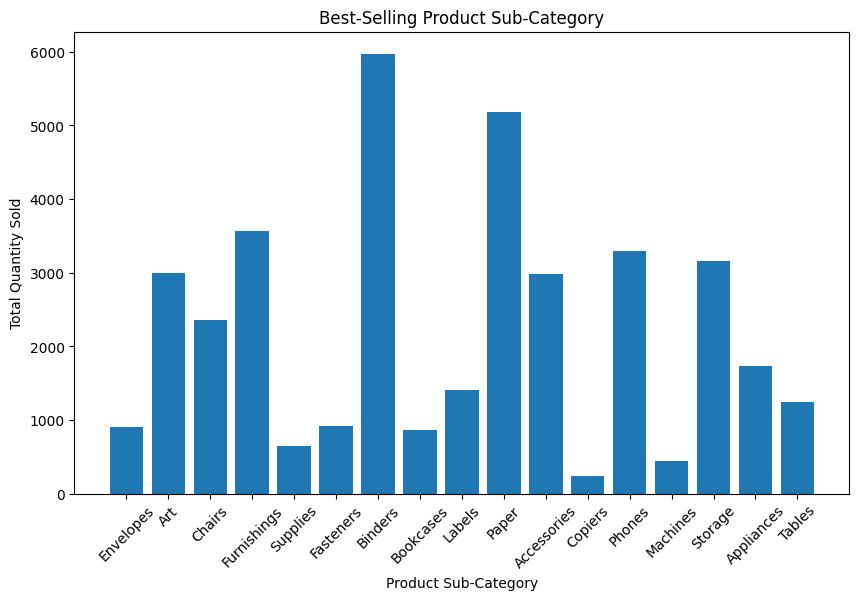

In [35]:
import matplotlib.pyplot as plt

# Calculating best-selling product sub-category
best_selling_df = df.groupBy("Sub-Category").sum("Quantity").withColumnRenamed("sum(Quantity)", "Total_Quantity")
best_selling_pd = best_selling_df.toPandas() # Convert to Pandas DataFrame for plotting

# Bar chart for best-selling product sub-category
plt.figure(figsize=(10, 6))
plt.bar(best_selling_pd["Sub-Category"], best_selling_pd["Total_Quantity"])
plt.xlabel('Product Sub-Category')
plt.ylabel('Total Quantity Sold')
plt.title('Best-Selling Product Sub-Category')
plt.xticks(rotation=45)
plt.show()

In [28]:
# Best-Selling Product Sub-Category

from pyspark.sql.functions import sum as spark_sum

# Group by Sub-Category and sum Quantity
best_selling_sub_category = df.groupBy("Sub-Category").agg(spark_sum("Quantity").alias("Total_Quantity")).orderBy(col("Total_Quantity").desc()).first()

print("Best-Selling Product Sub-Category:", best_selling_sub_category["Sub-Category"])


Best-Selling Product Sub-Category: Binders


In [29]:
# Product Category Generating the Highest Revenue

# Group by Category and sum Sales
highest_revenue_category = df.groupBy("Category").agg(spark_sum("Sales").alias("Total_Sales")).orderBy(col("Total_Sales").desc()).first()

print("Product Category Generating Highest Revenue:", highest_revenue_category["Category"])


Product Category Generating Highest Revenue: Technology


In [30]:
# Top 10 Most Valuable Customers

# Group by Customer Name and sum Sales
top_10_customers = df.groupBy("Customer Name").agg(spark_sum("Sales").alias("Total_Sales")).orderBy(col("Total_Sales").desc()).limit(10)

top_10_customers.show()


+------------------+------------------+
|     Customer Name|       Total_Sales|
+------------------+------------------+
|       Sean Miller|  25043.0504860878|
|      Tamara Chand|19052.217195034027|
|      Raymond Buch|15117.338958740234|
|      Tom Ashbrook|14595.619864463806|
|     Adrian Barton| 14473.57124376297|
|      Ken Lonsdale|14175.228905081749|
|      Sanjit Chand|14142.334137916565|
|      Hunter Lopez|12873.297662734985|
|      Sanjit Engle|12209.438140392303|
|Christopher Conant| 12129.07153737545|
+------------------+------------------+



In [31]:
# State Responsible for the Highest Number of Orders

# Count orders by State
state_with_most_orders = df.groupBy("State").count().orderBy(col("count").desc()).first()

print("State Responsible for the Highest Number of Orders:", state_with_most_orders["State"])


State Responsible for the Highest Number of Orders: California


In [32]:
# Year with Highest Revenue Generation

# Extract the year from Order Date
df = df.withColumn("Order Year", year(col("Order Date")))

# Group by Order Year and sum Sales
highest_revenue_year = df.groupBy("Order Year").agg(spark_sum("Sales").alias("Total_Sales")).orderBy(col("Total_Sales").desc()).first()

print("Year with Highest Revenue Generation:", highest_revenue_year["Order Year"])


Year with Highest Revenue Generation: 2017
